In [1]:
import cartopy.crs as ccrs
from datetime import datetime, timedelta,timezone
import matplotlib.pyplot as plt
import xarray as xr

from ONCToolbox import ONCToolbox
from ONCToolbox.utils import nan_onc_flags, remove_onc_flag_vars
from ONCToolbox.utils.profilers import split_periods
from ONCToolbox.utils.locations import BCFTerminal

In [2]:
end_datetime = datetime.now(timezone.utc).replace(tzinfo=None)
begin_datetime = end_datetime - timedelta(hours = 16)

In [3]:
onct = ONCToolbox()

In [4]:
doi = onct.find_data('TWSB', ['NAV', 'TSG','TURBCHLFL','PVCS'], begin_datetime, end_datetime)

In [5]:
datasets = []
for loc_code, dev_deps in doi.items():
    for dcc, dep_info in dev_deps.items():
        data = onct.get_data(loc_code, dcc, begin_datetime=begin_datetime,end_datetime=end_datetime)
        data = nan_onc_flags(data)
        data = remove_onc_flag_vars(data)

        data = data.drop_vars(['leak_indicator','tank_level'], errors = 'ignore')

        datasets.append(data)
ds = xr.combine_by_coords(datasets, combine_attrs='drop_conflicts')

for linterp in ['latitude','longitude','speed_over_ground','outlet_flow','pump_current']:
    ds[linterp] = ds[linterp].interpolate_na(dim = 'time', fill_value = 'extrapolate',max_gap = timedelta(milliseconds = 2000), method = 'linear')

for ninterp in ['system_state','valve_position']:
    ds[ninterp] = ds[ninterp].interpolate_na(dim = 'time', fill_value = 'extrapolate',max_gap = timedelta(milliseconds = 10000), method = 'nearest')

# Remove data that does not represent environment.
ds = ds.where(ds.system_state == 1, drop = True)
ds = ds.where(ds.valve_position == 1, drop = True)
ds = ds.where(ds.outlet_flow >= 1, drop = True)
ds = ds.where(ds.pump_current >= 1, drop = True)

In [6]:
transit_times = split_periods(ds)
last_transit = ds.sel(time = slice(transit_times[-1]['begin_datetime'], transit_times[-1]['end_datetime']))

In [9]:
sal_vmin, sal_vmax = last_transit.practical_salinity.quantile([0.025,0.975])
turb_vmin, turb_vmax = last_transit.turbidity.quantile([0.025,0.975])

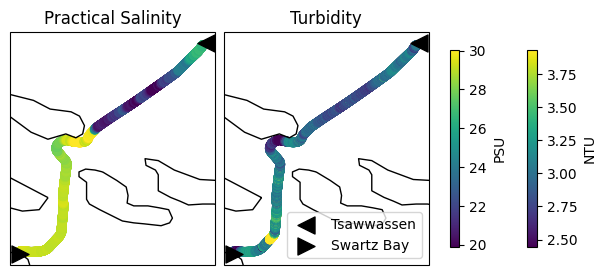

In [10]:
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(1,2, figsize = (6,5), constrained_layout = True, subplot_kw={'projection': crs})

s0 = ax[0].scatter(last_transit.longitude, last_transit.latitude, c = last_transit.practical_salinity, vmin = sal_vmin,vmax = sal_vmax)
s1 = ax[1].scatter(last_transit.longitude, last_transit.latitude, c = last_transit.turbidity, vmin = turb_vmin,vmax = turb_vmax)


for i in range(2):
    ax[i].scatter(BCFTerminal.Tsawwassen.lon, BCFTerminal.Tsawwassen.lat, label = 'Tsawwassen', marker = '<', color = 'black', s = 150)
    ax[i].scatter(BCFTerminal.SwartzBay.lon, BCFTerminal.SwartzBay.lat, label = 'Swartz Bay', marker = '>', color = 'black', s = 150)
    ax[i].coastlines()
    
ax[0].set_title('Practical Salinity')
ax[1].set_title('Turbidity')

ax[1].legend(loc = 'lower right')


fig.colorbar(s1, ax = [ax[0],ax[1]], shrink = 0.4, label = 'NTU')
fig.colorbar(s0, ax = [ax[0],ax[1]], shrink = 0.4, label = 'PSU')

